## Multivariate Time Series Forecasting with Deep Learning
### Predicting the price of Bitcoin and interpreting the results

This notebook runs the entire forecasting pipeline from data preparation to model training and interpretation.

Alternatively, everything can be run from the terminal as well (see README.md).

Prerequisite: Dataset has been downloaded (see README.md) and parameters have been updated if necessary (see /model/params.yaml).

### Setup

In [2]:
import os
import yaml
import importlib
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

os.chdir("../scripts")

import preprocess, train, inference, interpret

/Users/johannponitz/.pyenv/versions/3.6.9/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
with open("../model/params.yaml", "r") as params_file:
    params = yaml.safe_load(params_file)

data_dir = params['data_dir']

### Load and Prepare the Data

In [4]:
file_name = "BTC-USD.csv"
data = preprocess.load_data(file_name)
data.head(3)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-03-10,1189.359985,1270.469971,1077.250000,1116.719971,1116.719971,563795968
1,2017-03-11,1116.319946,1193.829956,1116.319946,1175.829956,1175.829956,283320000
2,2017-03-12,1176.619995,1226.979980,1175.359985,1221.380005,1221.380005,227176000


In [5]:
train_df, test_df = preprocess.prep_data(df=data, train_frac=0.5, plot_df=True)

Starting with data preparation...
Completed.


In [6]:
train_df.shape, test_df.shape

((913, 7), (913, 7))

### Explore the Data

In [7]:
plot_df = pd.read_csv(Path(data_dir, 'plot_df.csv'))
plot_df['Close_Change'] = plot_df.Close.pct_change(1)
plot_df = plot_df.dropna()

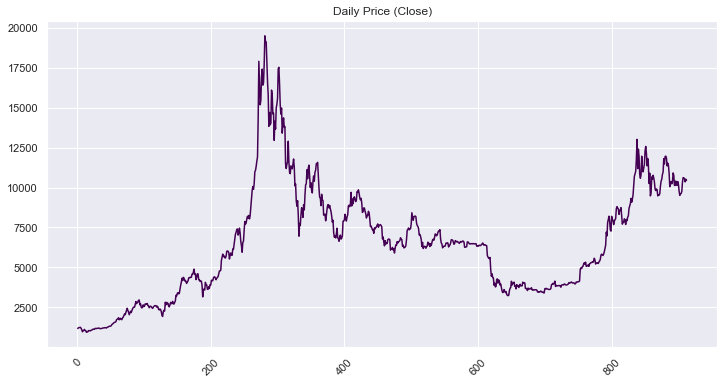

In [8]:
plot_df['Close'].plot(figsize=(12,6), rot=45, cmap='viridis')
plt.title('Daily Price (Close)')
plt.show()

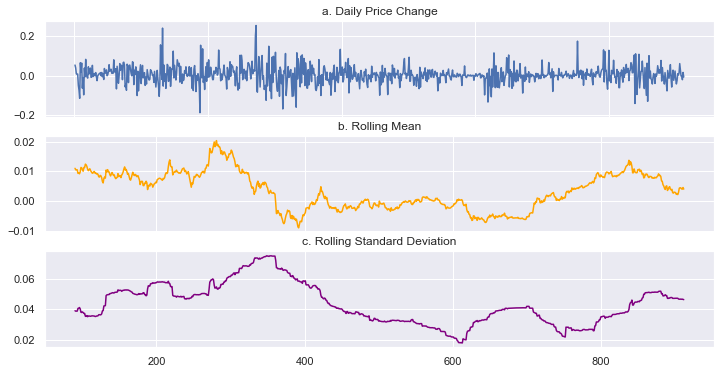

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=1)
plot_df['Close_Change'].plot(ax=axes[0], figsize=(12,6), rot=90, title='a. Daily Price Change', sharex=True)
plot_df['Close_Change'].rolling(90).mean().plot(ax=axes[1], figsize=(12,6), rot=90, title='b. Rolling Mean', color='orange')
plot_df['Close_Change'].rolling(90).std().plot(ax=axes[2], figsize=(12,6), rot=0, title='c. Rolling Standard Deviation', color='purple')
plt.show()

### Train the LSTM model

In [ ]:
sequence_length = 30
batch_size = 8
n_epochs = 20
n_epochs_stop = 5
label_name = 'Close'

In [ ]:
hist = train.train_model(train_df, test_df, label_name, sequence_length, batch_size, n_epochs, n_epochs_stop)

In [ ]:
hist.plot(figsize=(12,6), cmap='viridis')
plt.show()

### Evaluate the model

In [ ]:
predictions_descaled, labels_descaled = inference.predict(df=test_df,
                                                          label_name='Close',
                                                          sequence_length=sequence_length)

predictions_descaled.shape, predictions_descaled.shape

In [ ]:
print('Error on all test data:')
inference.print_loss_metrics(labels_descaled, predictions_descaled)
print('\n')
print('Error on partial test data:')
inference.print_loss_metrics(labels_descaled[:30], predictions_descaled[:30])

In [ ]:
# plot predictions vs true values
df_pred = pd.DataFrame()
df_pred['predicted'] = predictions_descaled
df_pred['true'] = labels_descaled
df_pred['residual'] = labels_descaled - predictions_descaled
df_pred.plot(figsize=(12,6), cmap='viridis')
plt.xticks(rotation=45)
#plt.xlim(0,300)
plt.xlabel('days')
plt.ylabel('price')
plt.legend()
plt.show()

### Find important features

In [12]:
from train import TimeSeriesDataset, TSModel
from torch.utils.data import DataLoader
import torch
import shap

In [13]:
background_data_size = 900
test_sample_size = 100
sequence_length = 30

In [44]:
importlib.reload(interpret)
shap_values, explainer = interpret.get_important_features_shapley(
    background_data_size,
    test_sample_size,
    sequence_length
)

(913, 7)
(100, 30, 7)
(30, 7)


In [ ]:
import numpy as np
shap_plot = pd.DataFrame(np.absolute(shap_values), columns=train_df.columns.tolist())
shap_plot['days'] = [i-31 for i in list(range(1,31))]
shap_plot.head()
shap_plot.iloc[-1]

In [ ]:
shap_plot.plot.area(x='days',figsize=(10, 6), cmap='viridis')
plt.title("Deep SHAP - Feature Importance")
plt.show()

In [ ]:
print(train_df.loc[-1])
print(predictions_descaled[-1])
print(labels_descaled[-1])
shap.force_plot(expected_value.expected_value, shap_values[index], train_df.loc[index], show=True, matplotlib=True)

In [ ]:
# plot predictions vs true values
df_pred = pd.DataFrame()
df_pred['predicted'] = predictions_descaled[-30:]
df_pred['true'] = labels_descaled[-30:]
df_pred.plot(figsize=(12,6), cmap='viridis')
plt.xticks(rotation=45)
#plt.xlim(0,300)
plt.xlabel('days')
plt.ylabel('price')
plt.legend()
plt.show()


# Yesterday
index = -1
print(train_df.loc[0])
print(shap_values[index])
shap.force_plot(predictions_descaled[-1], shap_values[index], train_df.loc[0], show=True)

In [ ]:
index=0
shap.initjs()
print(shap_values[0]) ## -30 Days

shap_values_reverse = shap_values
print(shap_values[-1])
print(data.iloc[-1])
shap.force_plot(predictions_descaled[-1], shap_values[index], train_df.loc[index], show=True)

In [ ]:
data.shape

In [15]:
import lime
import lime.lime_tabular

In [ ]:
def lime_explainer(j):
    explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, feature_names=x_train.columns.values.tolist(),
                                                  class_names=['PriceUSD'], verbose=True, mode='regression')
    exp = explainer.explain_instance(x_test.values[j], svr.predict, num_features=6)
    exp.show_in_notebook(show_table=True) # To show the predictions
    mylist = exp.as_list()
    print(mylist)

In [52]:
importlib.reload(train)
importlib.reload(interpret)


shap_values, explainer = interpret.get_important_features_lime(
    background_data_size,
    test_sample_size,
    sequence_length,
)



(913, 7)
torch.Size([100, 30, 7])
Intercept 0.25194046888366306
Prediction_local [0.45289685]
Right: tensor(0.5430, grad_fn=<SelectBackward0>)


{0: [(58, -0.03644855762940292), (59, -0.03546096286156345), (28, -0.03117967567422374), (29, -0.02962632064058972), (57, -0.02890332592794042), (56, -0.02072124252080422), (55, -0.0140940433121799), (148, -0.010980549208035451), (147, -0.009035834795969545), (88, -0.008402677945959388), (208, 0.007856749153653848), (54, -0.007761528588649625), (146, 0.007482405979369447), (207, 0.0072403954075245785), (209, 0.006826327820208895), (53, -0.005481793324133902), (177, 0.004795802642330389), (206, 0.0038786631300975166), (178, 0.003676236250392847), (176, 0.0034217991421772267), (87, 0.003406945842695992), (12, -0.0032638645218583283), (86, 0.0032403432012488233), (27, -0.002814134097612121), (52, -0.0027348494518736172), (205, 0.002652285466145462), (164, -0.0025023625677690446), (38, -0.0024164989906600124), (145, 0.0023933544813889273), (204, 0.0023790553414377077), (99, 0.0023294705533944285), (143, -0.0022270097568321203), (51, -0.002154500721562202), (92, 0.0021336322850272287), (76,

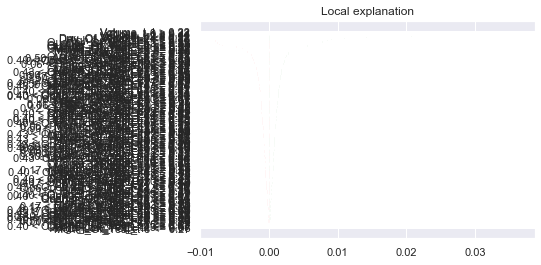

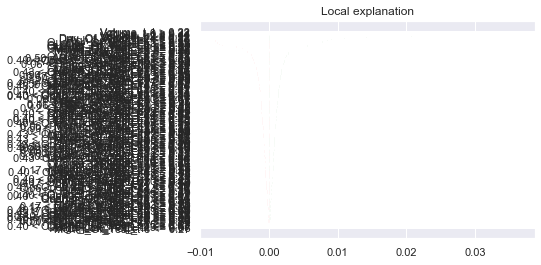

In [53]:
shap_values.show_in_notebook(show_table=True)

print(len(shap_values.as_list()))
shap_values.as_pyplot_figure()